# Introduction

Temperature is a major factor in our climate. It's variations have most influencial affects on the weather and hence forecasting it can prove very beneficial. In this project we are trying to forecast the temperature variations of New York City for the next few days based on the data collected for over 5 years from October 2012 to October 2017 on an hourly basis.

We'll be building and comparing the performance of different models based on the methods of Simple Moving Average, Simple Exponential Smoothing, Holt's Linear model, and Holt's Winter model.

## Exploratory Data Analysis

Let's first import our libraries and our data to check for nulls, and also get an idea about the size of our dataset.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

NYCData = pd.read_csv("data/NYC_temperaturedata.csv")
NYCData.head()

,Datetime,Temperature
0,2012-10-01 13:00:00,288.220000
1,2012-10-01 14:00:00,288.247676
2,2012-10-01 15:00:00,288.326940
3,2012-10-01 16:00:00,288.406203
4,2012-10-01 17:00:00,288.485467


In [2]:
#Checking if there are any nulls
NYCData.isna().any()

Datetime       False
Temperature    False
dtype: bool

So we have temperature readings in Fahrenheit on an hourly basis and thankfully no nulls! Let's go ahead and get the idea about the size of dataset that we have.

In [3]:
#Number of observations
NYCData.shape

(44460, 2)

We have close to 45,000 observations. Since we wish to forecast temperature in the terms of days and not hours, we shall convert this hourly basis observation to daily basis observation by taking the average/mean of the temperature observed for a given day. The assumption behind taking mean of the temperature here is that the temperature doesn't vary too drastically over a given day. But before we begin let's see if our Datetime column is actually of datetime data type or not.

In [4]:
NYCData["Datetime"].describe()

count                   44460
unique                  44460
top       2016-08-27 09:00:00
freq                        1
Name: Datetime, dtype: object

Hence, as the column isn't in fact a datetime type, we will convert it into datetime. Furthermore, we will drop the time variables in it and just keep the date variables so we can perform the average and condense our dataset to daily observation instead of hourly observation.

In [5]:
#Converting to datetime object
NYCData["Datetime"] = pd.to_datetime(NYCData["Datetime"], format='%Y-%m-%d')

#Keeping just the date value
NYCData["Datetime"] = NYCData["Datetime"].dt.date

NYCData.head()

,Datetime,Temperature
0,2012-10-01,288.220000
1,2012-10-01,288.247676
2,2012-10-01,288.326940
3,2012-10-01,288.406203
4,2012-10-01,288.485467


In [6]:
#Grouping the rows by date and taking the average for temperature
TemperatureData = pd.DataFrame({'Temperature' : NYCData.groupby("Datetime")["Temperature"].mean()}).reset_index()

## Forecasting

Before we begin with model building let's first look at the plot of our data.

In [7]:
#For plotting graphs
import matplotlib.pyplot as plt

#Creating datetime as index for plotting
TemperatureData.index = TemperatureData["Datetime"]

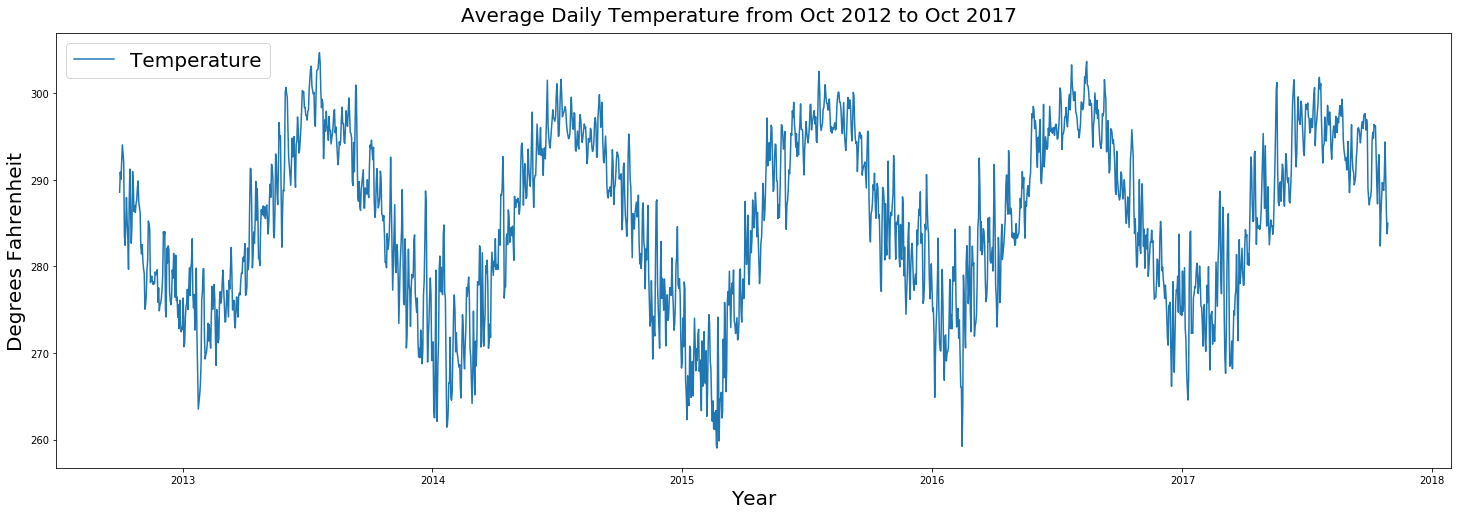

In [8]:
#Plotting temperature against time
TemperatureData["Temperature"].plot(figsize=(25,8), label='Temperature')
plt.figtext(.35,.9,'Average Daily Temperature from Oct 2012 to Oct 2017 ', fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

There's an obvious pattern or seasonality to our data. This seasonality is of a major concern to us when it comes to forecasting. But before we dive into it, let's first split our data into training and testing data as 80% and 20% of the original respectively. After that, we will visualize the data points of each split using different colors on our plot.

In [9]:
split = round(0.80 * len(TemperatureData))

TrainData = TemperatureData.iloc[0:split]
TestData = TemperatureData.iloc[(split):len(TemperatureData)]

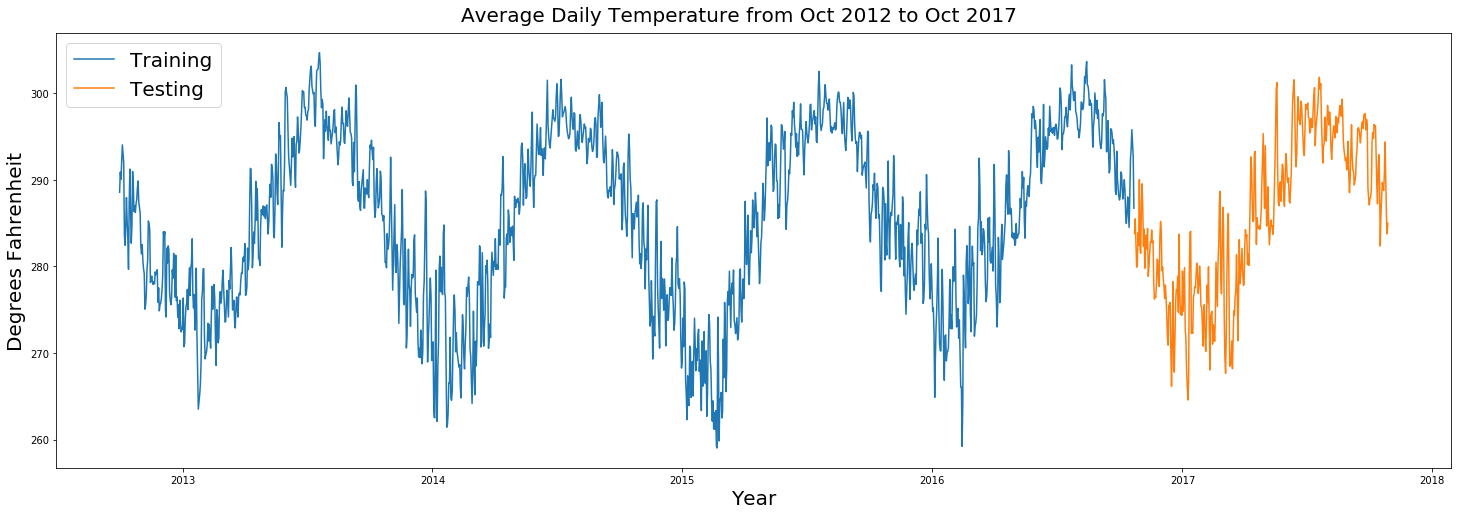

In [10]:
TrainData["Temperature"].plot(figsize=(25,8), label='Training')
TestData["Temperature"].plot(figsize=(25,8), label='Testing')
plt.figtext(.35,.9,'Average Daily Temperature from Oct 2012 to Oct 2017 ', fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

### Simple Moving Average

This technique takes the average of the last few known values to forecast the future values. So we'll assume that the future temperature values are affected by the last 7 day's values. We calculate the same and plot it as follows:

In [11]:
forecast_temp = TestData.copy()

#Moving Average of last 7 days of training data 
forecast_temp["SMA"] = TrainData["Temperature"].rolling(7).mean().iloc[-1]

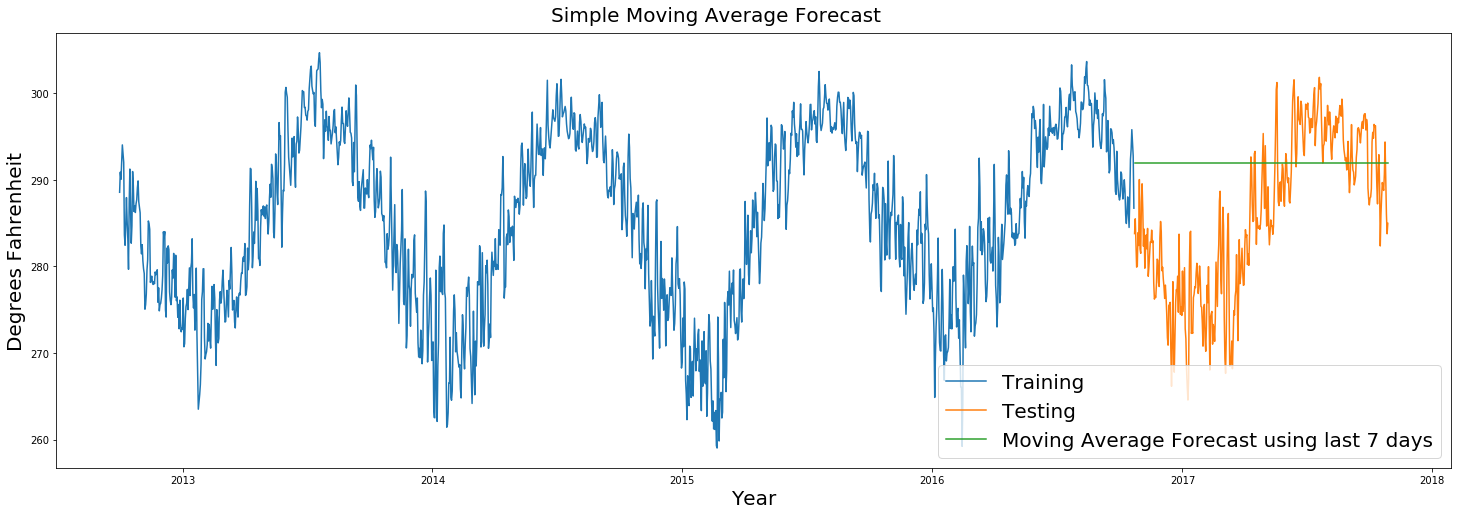

In [12]:
TrainData["Temperature"].plot(figsize=(25,8), label='Training')
TestData["Temperature"].plot(figsize=(25,8), label='Testing')
forecast_temp["SMA"].plot(figsize=(25,8), label='Moving Average Forecast using last 7 days')
plt.figtext(.4,.9,'Simple Moving Average Forecast', fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

Let's calculate the root mean squared error of the forecast so we can compare it's performance quantitatively with other techniques.

In [13]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

RMSE_SMA7 = sqrt(mse(forecast_temp["SMA"], TestData["Temperature"]))
print(RMSE_SMA7)

10.840358090003141


Let's see if we can reduce this error value by considering the temperature of last 30 days i.e. a whole month.

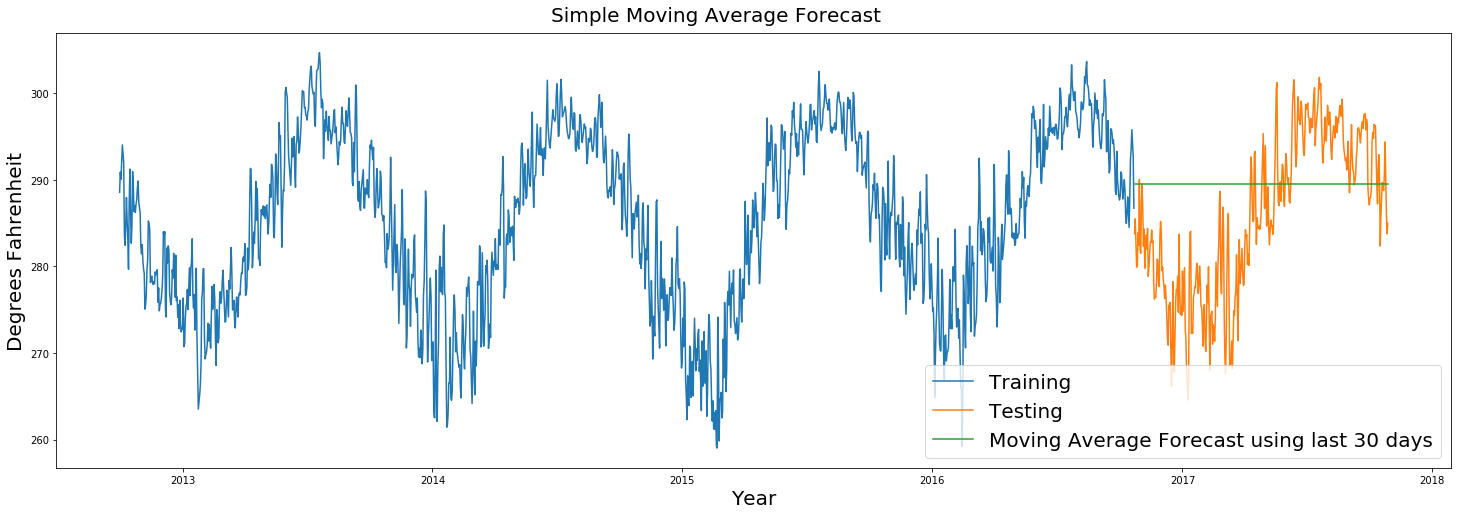

In [14]:
forecast_temp["SMA"] = TrainData["Temperature"].rolling(30).mean().iloc[-1]
TrainData["Temperature"].plot(figsize=(25,8), label='Training')
TestData["Temperature"].plot(figsize=(25,8), label='Testing')
forecast_temp["SMA"].plot(figsize=(25,8), label='Moving Average Forecast using last 30 days')
plt.figtext(.4,.9,'Simple Moving Average Forecast', fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

In [15]:
RMSE_SMA30 = sqrt(mse(forecast_temp["SMA"], TestData["Temperature"]))
print(RMSE_SMA30)

9.701984821683691


The RMSE value did decrease when we increase the size of our observation window.

### Simple Exponential Smoothing

In this technique, we assign larger weights to more recent observations than to observations from the distant past. The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

In [16]:
from statsmodels.tsa.api import SimpleExpSmoothing as ses

#Fitting a Simple Exponential Smooting model
fit1 = ses(np.asarray(TrainData["Temperature"])).fit(smoothing_level=0.6,optimized=False)

#Forecasting using trained model
forecast_temp["SES"] = fit1.forecast(len(TestData))

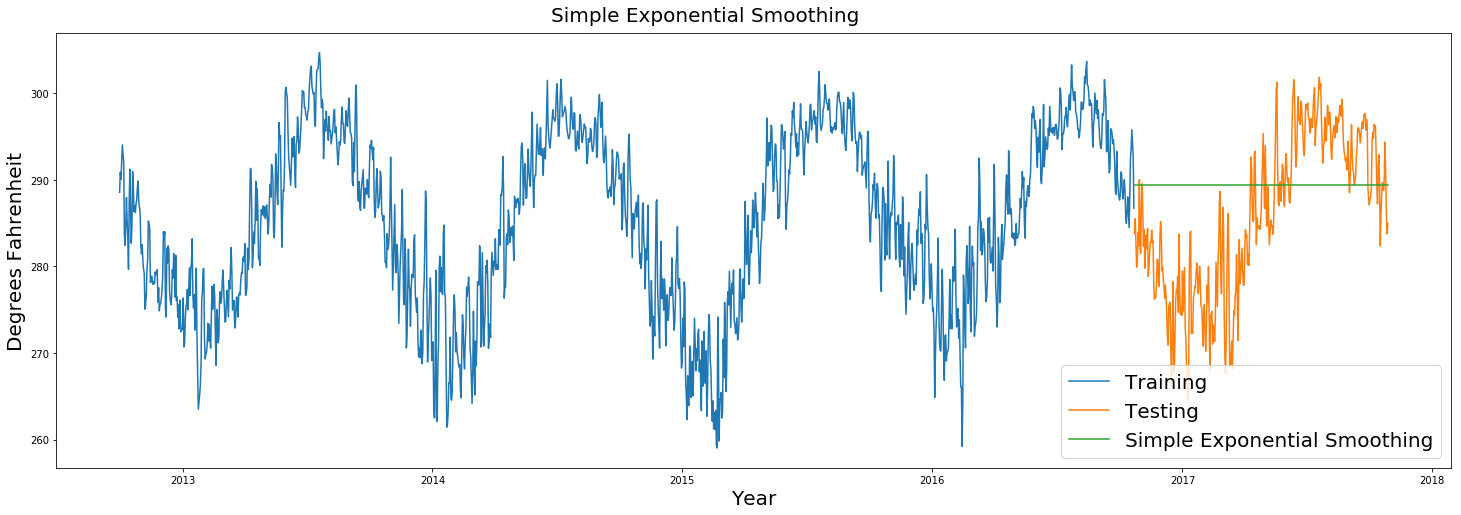

In [17]:
TrainData["Temperature"].plot(figsize=(25,8), label='Training')
TestData["Temperature"].plot(figsize=(25,8), label='Testing')
forecast_temp["SES"].plot(figsize=(25,8), label='Simple Exponential Smoothing')
plt.figtext(.4,.9,'Simple Exponential Smoothing', fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

In [18]:
#Calculating RMSE
RMSE_SES = sqrt(mse(forecast_temp["SES"], TestData["Temperature"]))
RMSE_SES

9.672831810524217

Evidently, Simple Exponential Smoothing performed just slightly better than SMA over past 30 days.

### Holt's Linear model

Holt's Linear model is a type of exponential smoothing that is best suited for series that has some trend associated with it. Simpler models, such as the ones discussed earlier, do not tend to take the trend of the time series into consideration. Before we build this model though, it'd be better to confirm that the series does in fact has a trend.

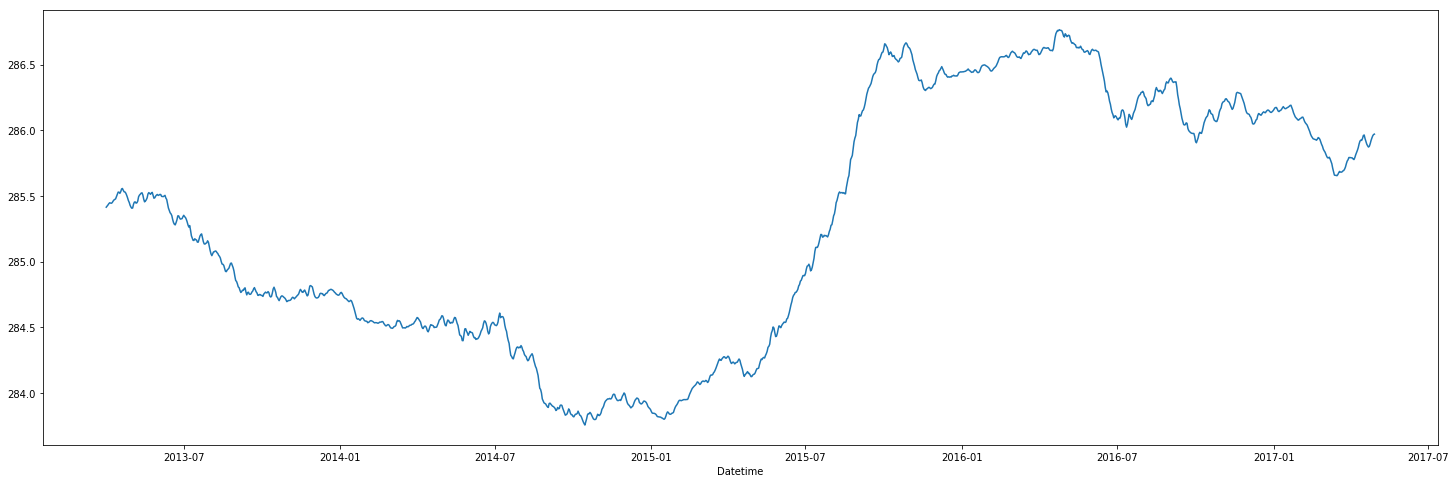

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(TemperatureData["Temperature"], freq = 365)

trend = decomposition.trend
trend.plot(figsize=(25,8), label='Trend')
plt.show()

Now that it's been confirmed that there seems to be an increasing trend in temperature we can build a Holt's Linear model.

In [20]:
from statsmodels.tsa.api import Holt
fit2 = Holt(np.asarray(TrainData["Temperature"])).fit(smoothing_level = 0.50,smoothing_slope = 0.1)
forecast_temp["HL"] = fit2.forecast(len(TestData))

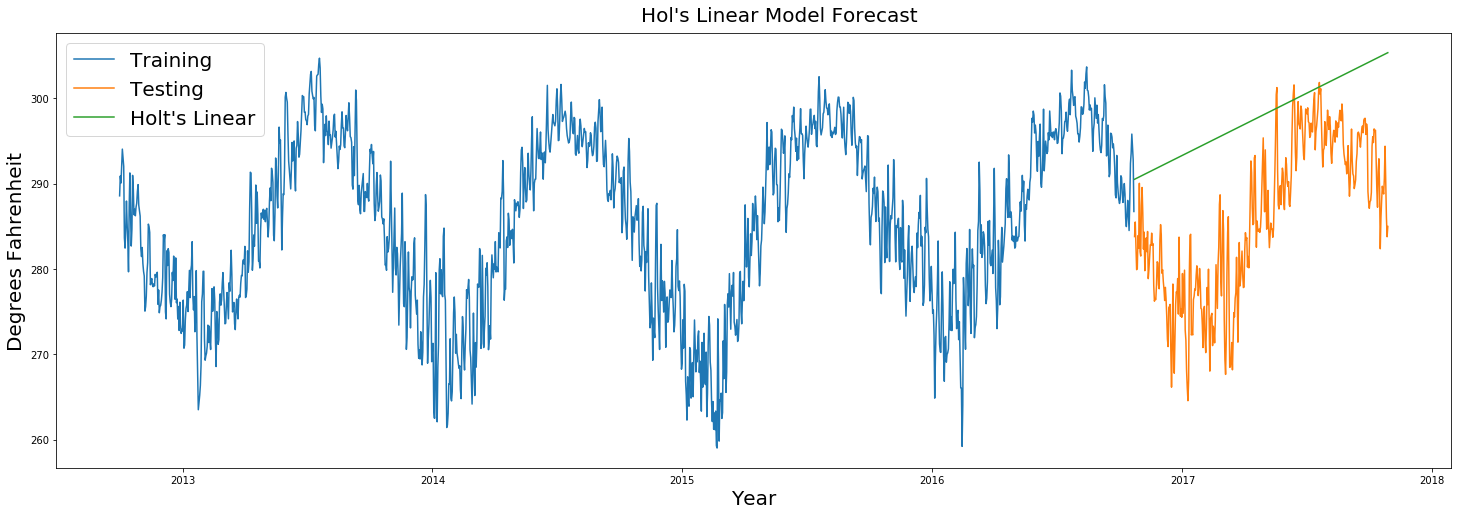

In [21]:
TrainData["Temperature"].plot(figsize=(25,8), label='Training')
TestData["Temperature"].plot(figsize=(25,8), label='Testing')
forecast_temp["HL"].plot(figsize=(25,8), label="Holt's Linear")
plt.figtext(.45,.9,"Hol's Linear Model Forecast", fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

In [22]:
RMSE_HL = sqrt(mse(forecast_temp["HL"], TestData["Temperature"]))
RMSE_HL

13.695024434937373

By the RMSE it is evident that Holt's Linear model performs very poorly for this time series. The reason for this is that the time series isn't that strong in terms of trend but rather seasonality and hence we require a method that takes seasonality into consideration.

### Holt's Winter model 

As I mentioned earlier, our data seems to be having a pattern i.e. a seasonality to it. For time series that have seasonality it is desirable that a forecasting model takes into account this recurring pattern. Holt's Winter model is a type of exponential smoothing technique which does just that. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend of the time series.

Here we will have to decide a "seasonal_period" parameter which basically means on what intervals does a pattern exist. We'll move forward with the assumption that the pattern repeats after 12 months since we have 4 different seasons every year which leads to a different average temperature in each of the seasons. It is best if we observe this seasonality in a graphical format rather than assuming it.

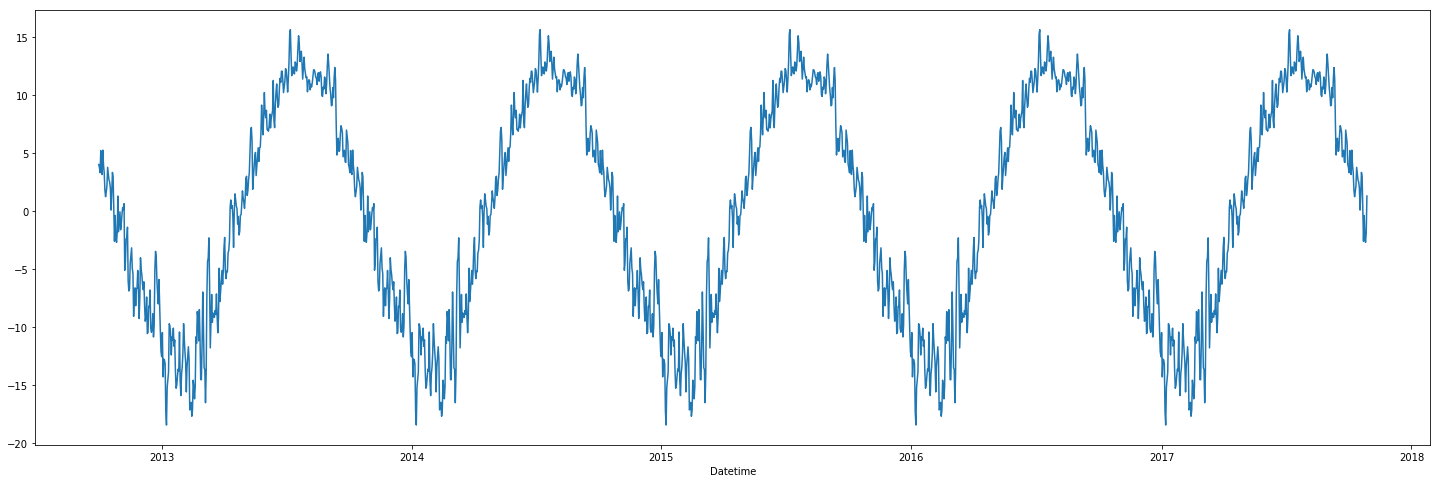

In [23]:
#Seasonality of the data
seasonal = decomposition.seasonal
seasonal.plot(figsize=(25,8), label='Seasonality')
plt.show()

The plot verifies our hypothesis that the temperature has a seasonal pattern of 12 months i.e. one whole year. So now we can proceed with modelling our forecasting model.

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing as es

fit3 = es(np.asarray(TrainData["Temperature"]) ,seasonal_periods=365 ,trend='add', seasonal='add',).fit()
forecast_temp["HW"] = fit3.forecast(len(TestData))

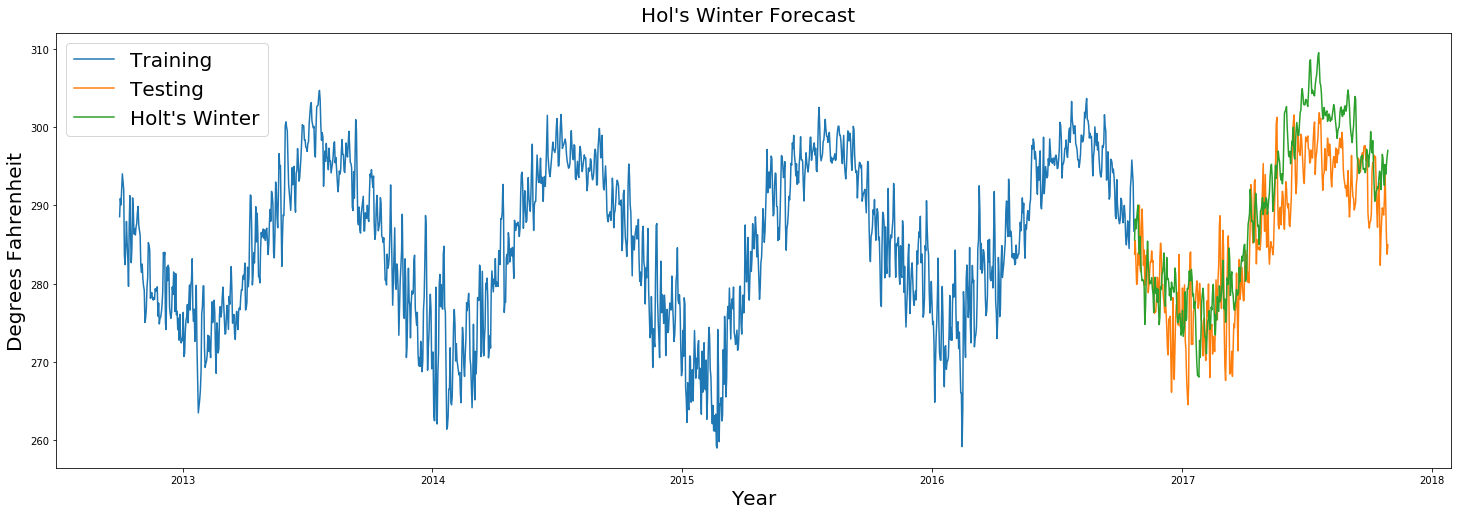

In [25]:
TrainData["Temperature"].plot(figsize=(25,8), label='Training')
TestData["Temperature"].plot(figsize=(25,8), label='Testing')
forecast_temp["HW"].plot(figsize=(25,8), label="Holt's Winter")
plt.figtext(.45,.9,"Hol's Winter Forecast", fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

In [26]:
RMSE_HW = sqrt(mse(forecast_temp["HW"], TestData["Temperature"]))
RMSE_HW

6.269841060895441

Holt's Winter model performed marvelously! RMSE dropped by 3 points and I think the graph speaks for itself. The model's plotted lines are very close to the actual values. But let's have a closer look at the plot by just focusing on the testing data and the forecasted data.

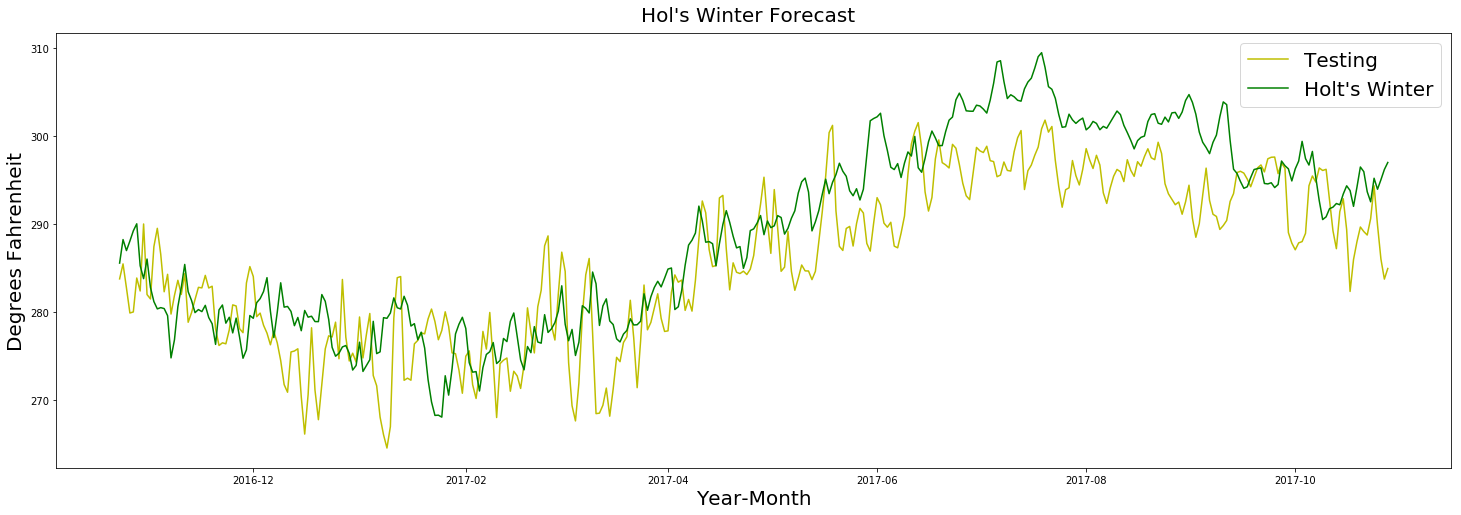

In [28]:
TestData["Temperature"].plot(figsize=(25,8), label='Testing', color = 'y')
forecast_temp["HW"].plot(figsize=(25,8), label="Holt's Winter", color = 'g')
plt.figtext(.45,.9,"Hol's Winter Forecast", fontsize=20)
plt.xlabel("Year-Month", fontsize=20)
plt.ylabel("Degrees Fahrenheit", fontsize=20)
plt.legend(loc='best', prop={'size':20})
plt.show()

So we notice that the forecast produces values that are pretty close to the actual values. The plot of predicted values (green) runs along with actual values (yellow) fairly well but there are some observations for which the predicted values differ greatly, especially for the higher values of temperature. The reason for this can be inferred from the trend of the series. On observation it can be seen that the there is a substantial rise in temperature for a long time and then it starts to fall gradually. Due to this steady increase in temperature, the algorithm creates a model in which higher temperature differ a lot from the actual values. This also explains the poor performance of the linear model.

Nevertheless, this model outperforms every other model on account of its lowest RMSE value which can be attributed to the fact that the model takes the seasonality of the time series into consideration.